In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os
from GlvSolver import *

# Generate synthetic data
The synthetic model generates longitudinal microbiome data of two subjects (S1 and S2). The microbial community of both subjects contains three bacterial taxa (y0, y1, y2).

In [2]:
def toy_model(y, t, SubjectID):
    
    alpha = np.array([0.50,  0.50,  0.50])
    beta = np.array([[-0.1, -0.04, -0.04],
                     [0.04, -0.10,  -0.02],
                     [0.02,  0.04, -0.10]])
    epsilon1 = np.array([0.3, -0.5, -0.3])
    epsilon2 = np.array([1.0,  0.0, -1.0])
    
    
    dydt = [0, 0, 0]
    for i in [0,1,2]:
        dydt[i] += alpha[i]*y[i] + beta[i,0]*y[i]*y[0] + beta[i,1]*y[i]*y[1] + beta[i,2]*y[i]*y[2]
        
    # here we simulated two perturbations
    # the first perturbation adds a sine wave to subject S1 and a cosine wave to subject S2
    # the second perturbation adds a square wave to subject S1 when t<=10 and to subject S2 when t>10
    if SubjectID == "S1":
        for i in [0,1,2]:
            if t<=10:
                dydt[i] += epsilon1[i]*np.sin(t)*y[i] + epsilon2[i]*1.0*y[i]
            else:
                dydt[i] += epsilon1[i]*np.sin(t)*y[i]
    elif SubjectID == "S2":
        for i in [0,1,2]:
            if t>10:
                dydt[i] += epsilon1[i]*np.cos(t)*y[i] + epsilon2[i]*1.0*y[i]
            else:
                dydt[i] += epsilon1[i]*np.cos(t)*y[i]

    return dydt

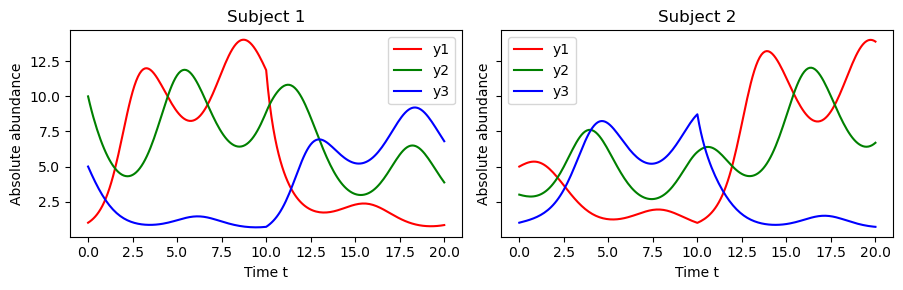

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,3), sharex=True, sharey=True)

t = np.linspace(0, 20, 201)

y0_S1 = [1, 10, 5]
sol_S1 = odeint(toy_model, y0_S1, t, args=('S1',))
_ = ax[0].plot(t, sol_S1[:,0], 'r', label='y1')
_ = ax[0].plot(t, sol_S1[:,1], 'g', label='y2')
_ = ax[0].plot(t, sol_S1[:,2], 'b', label='y3')
_ = ax[0].legend(loc='best')
_ = ax[0].set_xlabel('Time t')
_ = ax[0].set_ylabel('Absolute abundance')
_ = ax[0].set_title('Subject 1')

y0_S2 = [5, 3, 1]
sol_S2 = odeint(toy_model, y0_S2, t, args=('S2',))
_ = ax[1].plot(t, sol_S2[:,0], 'r', label='y1')
_ = ax[1].plot(t, sol_S2[:,1], 'g', label='y2')
_ = ax[1].plot(t, sol_S2[:,2], 'b', label='y3')
_ = ax[1].legend(loc='best')
_ = ax[1].set_xlabel('Time t')
_ = ax[1].set_ylabel('Absolute abundance')
_ = ax[1].set_title('Subject 2')

plt.tight_layout()
plt.show()

# Generate the input table to GlvSolver
The input table has the following columns: subject id, sample id, time point, pertubation id 1, perturbation id 2, ..., perturbation id n, followed by taxon id 1, taxon id 2, ..., taxon id n. Perturbation ids must start with "Perturbation_", and Taxon ids must start with "Taxon_".

In [4]:
row = [] # each row of the input table
for traj_id in ['S1','S2']:
    for k,curr_t in enumerate(t):
        sample_id = '%s_t%s'%(traj_id,str(round(curr_t,3)))
        if traj_id=='S1':
            if curr_t<=10:
                row.append([traj_id, sample_id, curr_t, np.sin(curr_t), 1.0]+list(sol_S1[k,:]))
            else:
                row.append([traj_id, sample_id, curr_t, np.sin(curr_t), 0.0]+list(sol_S1[k,:]))
        elif traj_id=='S2':
            if curr_t>10:
                row.append([traj_id, sample_id, curr_t, np.cos(curr_t), 1.0]+list(sol_S2[k,:]))
            else:
                row.append([traj_id, sample_id, curr_t, np.cos(curr_t), 0.0]+list(sol_S2[k,:]))
df_input = pd.DataFrame(row, columns=['SubjectID','SampleID','Timepoint','Perturbation_Periodic','Perturbation_Square','Taxon_1','Taxon_2','Taxon_3'])
df_input.head()

,SubjectID,SampleID,Timepoint,Perturbation_Periodic,Perturbation_Square,Taxon_1,Taxon_2,Taxon_3
0,S1,S1_t0.0,0.0,0.000000,1.0,1.000000,10.000000,5.000000
1,S1,S1_t0.1,0.1,0.099833,1.0,1.086264,9.461864,4.713225
2,S1,S1_t0.2,0.2,0.198669,1.0,1.186190,8.962964,4.433857
3,S1,S1_t0.3,0.3,0.295520,1.0,1.301657,8.498013,4.163142
4,S1,S1_t0.4,0.4,0.389418,1.0,1.434783,8.063239,3.902104


# Run GlvSolver and generate the input files to CMDStan

In [5]:
df_output, scaling_factor = compute_dlogy_dt(df_input, method='spline')
df_output.head()

,SubjectID,SampleID,Timepoint,Perturbation_Periodic,Perturbation_Square,Taxon_1,Taxon_2,Taxon_3,DLOGDT_Taxon_1,DLOGDT_Taxon_2,DLOGDT_Taxon_3
0,S1,S1_t0.0,0.0,0.000000,1.0,0.071236,0.712362,0.356181,0.79995,-0.55979,-0.58001
1,S1,S1_t0.1,0.1,0.099833,1.0,0.077381,0.674027,0.335752,0.854334,-0.546972,-0.601071
2,S1,S1_t0.2,0.2,0.198669,1.0,0.084500,0.638488,0.315851,0.905106,-0.536845,-0.620745
3,S1,S1_t0.3,0.3,0.295520,1.0,0.092725,0.605366,0.296566,0.952045,-0.528761,-0.639017
4,S1,S1_t0.4,0.4,0.389418,1.0,0.102209,0.574395,0.277971,0.994733,-0.521682,-0.655811


In [6]:
Xmat, Ymat, sample_ids, taxa_ids, perturbation_ids = generate_XY_matrics(df_output)

In [7]:
write_stan_input_file('test_glv', 'test_glv/', Xmat, Ymat, taxa_ids, perturbation_ids, neg_self_int=True)

# Run CMDStan (go to test_glv folder and run "./run_cmdstan.sh")

# Parse CMDStan outputs

In [8]:
stan_output_path = ["test_glv/test_glv_%d.csv"%(i) for i in np.arange(1,4)]
df_parsed = parse_stan_output(stan_output_path, taxa_ids, perturbation_ids, scaling_factor=scaling_factor).sort_values('Variable').set_index("Variable")
df_parsed

,Taxon1,Taxon2,Mean,STD,95CI_left,95CI_right,Sig
Variable,,,,,,,
alpha_Taxon_1,Taxon_1,growth,0.493551,0.009596,0.475567,0.511949,True
alpha_Taxon_2,Taxon_2,growth,0.500259,0.009110,0.481997,0.516476,True
alpha_Taxon_3,Taxon_3,growth,0.505586,0.009251,0.487857,0.522957,True
beta_Taxon_1_Taxon_1,Taxon_1,Taxon_1,-0.100093,0.000736,-0.101606,-0.098792,True
beta_Taxon_1_Taxon_2,Taxon_1,Taxon_2,-0.040522,0.000845,-0.042172,-0.038977,True
beta_Taxon_1_Taxon_3,Taxon_1,Taxon_3,-0.038124,0.001157,-0.040469,-0.036067,True
beta_Taxon_2_Taxon_1,Taxon_2,Taxon_1,0.039984,0.000737,0.038637,0.041513,True
beta_Taxon_2_Taxon_2,Taxon_2,Taxon_2,-0.100010,0.000869,-0.102045,-0.098537,True
beta_Taxon_2_Taxon_3,Taxon_2,Taxon_3,-0.020019,0.001115,-0.022339,-0.017944,True
